In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [78]:
ldf = pd.DataFrame()

for i in np.arange(3, 4):
    model_path_LSTM = f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20250324/BEAC/BEAC_fh{i}_u_total_HRRR_ml_output_linear.parquet"

    # Read parquet file
    ldf_ = pd.read_parquet(model_path_LSTM)

    # Concatenate with the main DataFrame
    ldf = pd.concat([ldf_, ldf], ignore_index=True)
    print(ldf.shape)

# Sort by valid_time
ldf = ldf.sort_values(by="valid_time").reset_index(drop=True)

(55321, 4)


In [79]:
import sys

sys.path.append("..")

from src.data import nysm_data
from src.data import gfs_data
from src.data import nam_data

In [80]:
nysm_df = nysm_data.load_nysm_data(gfs=False)
# nysm_df = nysm_df.rename(columns={'time_1H':'valid_time'})
# gfs_df = gfs_data.read_gfs_data('012')
station = "BEAC"

/home/aevans/nwp_bias/src/machine_learning/notebooks/../src/data/nysm_data.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nysm_1H_obs['snow_depth'].fillna(-999, inplace=True)
/home/aevans/nwp_bias/src/machine_learning/notebooks/../src/data/nysm_data.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [81]:
ldf.dropna(inplace=True)
ldf.head()

,target_error_lead_0,Model forecast,diff,valid_time
0,-0.333597,-1813.823364,998.673523,2018-01-01 03:00:00
1,0.555584,-1813.823364,999.562683,2018-01-01 04:00:00
2,0.555975,-1813.823364,999.563049,2018-01-01 05:00:00
3,-0.899626,-1813.823364,998.107483,2018-01-01 06:00:00
4,-0.605431,-1813.823364,998.401672,2018-01-01 07:00:00


In [82]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            f = int(len(df_test) * 0.5)
            df_val = df_test.iloc[:f]
            df_test = df_test[-f:]

    return df_train["valid_time"], df_test["valid_time"], df_val["valid_time"]

In [83]:
# ldf["valid_time"] = pd.to_datetime(ldf["valid_time"])

In [84]:
df_train, df_test, df_val = which_fold(ldf, 4)

In [85]:
test_set_start = df_test.iloc[0]
test_set_start

Timestamp('2024-04-09 04:00:00')

In [86]:
test_set_finish = df_test.iloc[-1]
test_set_finish

Timestamp('2024-12-14 23:00:00')

In [87]:
df_val.iloc[0]

Timestamp('2023-08-17 21:00:00')

In [88]:
df_val.iloc[-1]

Timestamp('2024-04-09 02:00:00')

In [89]:
def date_filter(ldf, time1, time2):
    ldf = ldf[ldf["valid_time"] > time1]
    ldf = ldf[ldf["valid_time"] < time2]

    return ldf

In [90]:
def met_output(df, station, fh):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df[f"u_total_{station}"]),
        c="mediumseagreen",
        linewidth=3,
        label="NAM Prediction",
    )

    plt.plot(
        np.array(x),
        np.array(df["reforecast"]),
        c="red",
        linewidth=3,
        linestyle="--",  # Dashed line
        label="LSTM Reforecast",
    )

    plt.plot(
        np.array(x),
        np.array(df[f"wspd_sonic_mean_{station}"]),
        c="black",
        linewidth=1,
        alpha=0.9,
        label="NYSM Observation",
    )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric, 0, 10, where=day_mask, color="white", alpha=0.5, label="Daytime"
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric, 0, 10, where=~day_mask, color="grey", alpha=0.2, label="Nighttime"
    )

    ax.set_title(f"GFS Prediction v NYSM Observation: {station}: FH{fh}", fontsize=28)
    # plt.ylim(-5, 5.)
    ax.legend()
    plt.show()

In [91]:
nysm_df.columns

Index(['station', 'valid_time', 'lat', 'lon', 'elev', 'tair', 'ta9m', 'td',
       'relh', 'srad', 'pres', 'mslp', 'wspd_sonic_mean', 'wspd_sonic',
       'wmax_sonic', 'wdir_sonic', 'snow_depth', 'precip_total'],
      dtype='object')

# TIME FILTER

In [99]:
time1 = datetime(2024, 3, 1, 0, 0, 0)
time2 = datetime(2024, 4, 15, 23, 0, 0)

ldf = date_filter(ldf, time1, time2)
nysm_df = date_filter(nysm_df, time1, time2)
# gfs_df = date_filter(gfs_df, time1, time2)

In [100]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def ml_output(
    df,
    fold,
    station,
    test_set_start,
    test_set_finish,
    fill_between_min,
    fill_between_max,
):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df["target_error_lead_0"]),
        c="black",
        linewidth=1,
        label="Target",
    )

    plt.plot(
        np.array(x),
        np.array(df["Model forecast"]),
        c="red",
        linewidth=3,
        alpha=0.7,
        label="LSTM Output",
    )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric,
        fill_between_min,
        fill_between_max,
        where=day_mask,
        color="white",
        alpha=0.5,
        label="Daytime",
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric,
        fill_between_min,
        fill_between_max,
        where=~day_mask,
        color="grey",
        alpha=0.2,
        label="Nighttime",
    )

    ax.set_title(f"HRRR Precip Error LSTM Output v Target: {station}", fontsize=28)
    # plt.ylim(-5, 5.)
    ax.legend()

    plt.show()

In [101]:
ldf.head()

,target_error_lead_0,Model forecast,diff,valid_time
48855,-2.253911,-1.182310,-0.564896,2024-03-01 01:00:00
48856,-1.090568,-0.153524,-0.871248,2024-03-01 02:00:00
48857,-0.334394,-0.870082,0.908581,2024-03-01 03:00:00
48858,-1.798028,-1.850701,0.845831,2024-03-01 04:00:00
48859,-1.652535,-1.641781,0.692866,2024-03-01 05:00:00


In [102]:
ldf["diff"] = ldf.iloc[:, 0] - ldf.iloc[:, 1]
ldf["Model forecast"] = ldf["Model forecast"] * 0.7

In [103]:
mean = st.mean(abs(ldf["diff"]))
mean

0.7642212181522723

In [104]:
mean_s = st.mean(ldf["diff"] ** 2)
mean_s

0.983344820349208

# MODEL OUTPUT

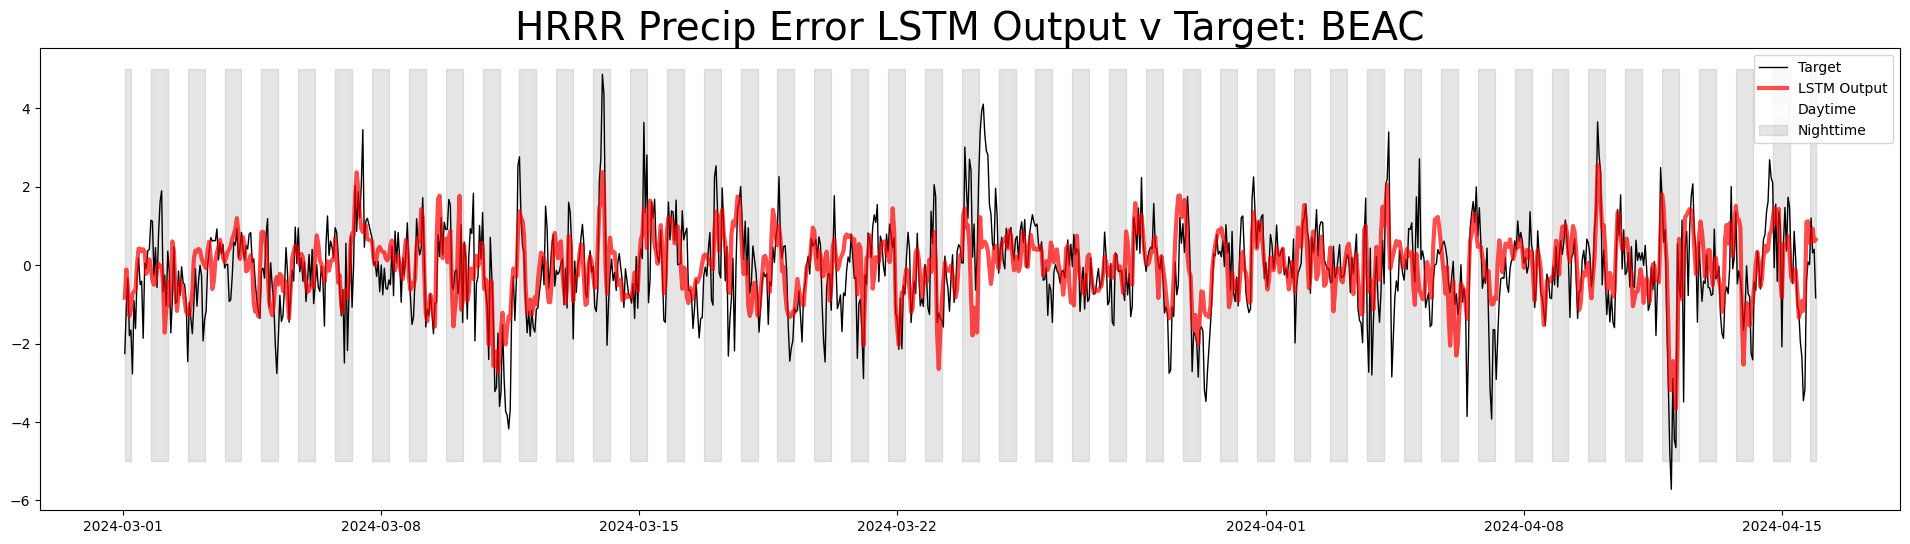

In [105]:
x = ml_output(ldf, 4, station, test_set_start, test_set_finish, -5, 5)

In [106]:
full_df["reforecast"] = full_df[f"u_total_{station}"] - full_df["diff"]
full_df["reforecast"] = full_df["reforecast"].apply(lambda x: max(x, 0))
met_output(full_df, "VOOR", fh)

NameError: name 'full_df' is not defined

In [ ]:
for k in full_df.columns:
    if re.search(
        f"{station}|valid|Model forecast|Abs_err",
        k,
    ):
        continue
    else:
        full_df = full_df.drop(columns=[k])

In [ ]:
# test_len = int(len(full_df['valid_time'])*0.2)
# full_df = full_df.iloc[0:test_len]

In [ ]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month), (df.valid_time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(1, len(the_list) + 1)
    plt.bar(x, the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])
    ax.set_xticks(np.arange(1, len(the_list) + 1, int((len(the_list) + 1) / 6)))
    return the_list

In [ ]:
full_df.head()

In [ ]:
create_hexbin_heatmap(ldf)

In [ ]:
create_scatterplot_heatmap(ldf)

In [ ]:
create_heatmap(ldf)

In [ ]:
err_by_month = groupby_month(ldf, "diff")
err_by_month

In [ ]:
def groupby_time(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.hour)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))
    plt.bar(x, the_list, color="g")
    return the_list

In [ ]:
err_by_time = groupby_time(ldf, "diff")

In [ ]:
import calendar


def groupby_month_total(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))

    # Get a colormap
    cmap = plt.get_cmap("RdBu")
    # Normalize your data to map to the colormap
    norm = plt.Normalize(min(the_list), max(the_list))
    colors = cmap(norm(the_list))

    # Create a bar chart
    plt.bar(x, the_list, color=colors)
    ax.set_xticks(x)  # Set x-ticks to be at the positions of the months
    month_labels = [calendar.month_name[month] for month in GB.index]
    ax.set_xticklabels(month_labels)  # Label x-ticks with month numbers

    plt.show()
    return the_list

In [ ]:
groupby_month_total(ldf, "diff")

In [ ]:
def myround(x, base):
    return base * round(x / base)

In [ ]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [ ]:
def err_bucket(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))

    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        err = full_df["Abs_err"].iloc[i]
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]

    return temp_df, instances

In [ ]:
def plot_buckets(temp_df, instances, var_name, cmap, width):
    my_cmap = plt.get_cmap(cmap)
    averages = temp_df / instances
    y = averages
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    the_list = averages.tolist()
    fig, ax = plt.subplots(
        figsize=(21, 6), facecolor="slategrey", constrained_layout=True
    )
    bars = plt.bar(temp_df.keys(), the_list, color=my_cmap(rescale(y)), width=width)
    ax.set_title("Absolute Error of LSTM", fontsize=28, c="white")
    ax.set_xlabel(var_name, fontsize=18, c="white")
    ax.set_ylabel("Mean Absolute Error", fontsize=18, c="white")
    # Iterating over the bars one-by-one
    # Annotate each bar with its value
    # Annotate each bar with the number of instances
    for bar, value, instance_count in zip(bars, the_list, instances):
        yval = value + 0.01  # Adjust the vertical position of the label
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"n={instance_count}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
        )

In [ ]:
# for k in full_df.keys():
#     print(k)

In [ ]:
# diector = sorted(os.listdir('/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/'))

# for d in diector:
#         full_df = pd.read_parquet(
#         f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/{d}"
#     )
#         for k in full_df.columns:
#             if re.search(
#                 f"{station}",
#                 k,
#             ):
#                 print("Succes!!")
#                 print(d)
#             else:
#                 continue

In [ ]:
# Reset index for both DataFrames to ensure alignment
full_df = full_df.reset_index(drop=True)
ldf = ldf.reset_index(drop=True)
full_df["Abs_err"] = ldf["diff"]

In [ ]:
full_df.dropna(inplace=True)

In [ ]:
temp_df, instances = err_bucket(full_df, f"tair_{station}", 2)

In [ ]:
instances

In [ ]:
plot_buckets(temp_df, instances, "Temperature (C)", "Wistia", 2.5)

In [ ]:
relh_df, instances = err_bucket(full_df, f"relh_{station}", 2)

In [ ]:
plot_buckets(relh_df, instances, "Relative Humidity (%)", "copper", 5.0)

In [ ]:
new_df, instances = err_bucket(full_df, f"srad_{station}", 40)

In [ ]:
plot_buckets(new_df, instances, "Solar Radiation (W / m*m)", "copper", 50.0)

In [ ]:
pres_df, instances = err_bucket(full_df, f"pres_{station}", 2)

In [ ]:
print(f'The mean pressure at {station} is {full_df[f"pres_{station}"].mean()}')

In [ ]:
plot_buckets(pres_df, instances, "Surface Pressure (mb)", "copper", 1.5)

In [ ]:
def round_small(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
            temps.append(rounded)
        else:
            rounded = myround(full_df[met_col].iloc[i], 1)
            temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))
    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
        else:
            rounded = float(myround(full_df[met_col].iloc[i], base=1))
        err = float(full_df["Abs_err"].iloc[i])
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]
    temp_df = temp_df.loc[~(temp_df == 0)]
    instances = instances.loc[~(instances == 0)]
    return temp_df, instances

In [ ]:
rain_df, instances = err_bucket(full_df, f"precip_total_{station}", 0.1)

In [ ]:
plot_buckets(rain_df, instances, "Precipitation [mm/hr]", "winter", 0.1)

In [ ]:
snow_df, instances = round_small(full_df, f"snow_depth_{station}", 2)

In [ ]:
snow_df = snow_df.iloc[1:]
instances = instances.iloc[1:]

In [ ]:
plot_buckets(snow_df, instances, "Accumulated Snow (m)", "cool", 0.01)

In [ ]:
wmax, instances = err_bucket(full_df, f"wmax_sonic_{station}", 2)

In [ ]:
plot_buckets(wmax, instances, "Wind Max (m/s)", "copper", 1.0)

In [ ]:
wdir, instances = err_bucket(full_df, f"wdir_sonic_{station}", 45)

In [ ]:
plot_buckets(wdir, instances, "Wind Dir (degrees)", "copper", 10.0)